# Chapter 4: Karplus Strong Algorithm

Adapted from: ["Python Playground: Geeky Projects for the Curious Programmer"](https://www.amazon.com/Python-Playground-2nd-Mahesh-Venkitachalam/dp/1718503040/ref=sr_1_4?keywords=python+playground&sr=8-4) by Mahesh Venkitachalam (No Starch Press)

This program implements the [Karplus–Strong string synthesis](https://en.wikipedia.org/wiki/Karplus%E2%80%93Strong_string_synthesis).  According to ChatGPT 4.0:

## ChatGPT 4.0 Output

The Karplus-Strong algorithm is a method used in digital signal processing and physical modeling synthesis to simulate the sound of a plucked string or percussion instruments. Developed by Kevin Karplus and Alex Strong in 1983, this algorithm is a simple yet powerful technique for synthesizing realistic string sounds and has been influential in the field of computer music.

### Basic Concept

The Karplus-Strong algorithm uses a concept known as a "wavetable synthesis". Here's how it works:

1. **Initial Noise Burst**: The algorithm starts with a buffer (wavetable) filled with random values. This buffer represents a noise burst, similar to the initial complex vibrations when a string is plucked.

2. **Circular Buffer Feedback Loop**: The buffer is treated as a circular buffer, meaning that once the playback reaches the end of the buffer, it wraps around to the start again. The contents of this buffer are continuously fed back into itself, creating a feedback loop.

3. **Low-Pass Filter**: Each time the buffer wraps around, the algorithm applies a simple low-pass filtering process. This usually involves averaging each sample with the next one (or with a small number of subsequent samples). This filtering simulates the energy loss in a real string due to factors like air resistance and internal friction.

4. **Resulting Sound**: The output sound is created by continuously reading the values from this buffer. The low-pass filtering gradually turns the initial noise into a harmonic wave, mimicking the behavior of a vibrating string.

### Characteristics and Usage

- **Realism and Simplicity**: The Karplus-Strong algorithm is renowned for its ability to produce realistic string-like sounds with a very simple implementation, making it computationally efficient.

- **Modifications for Different Sounds**: The algorithm can be modified to simulate different types of plucked string instruments. Adjusting the initial conditions (like the noise burst) and parameters (like the low-pass filter and the buffer length, which determines the pitch) allows for a variety of sounds.

- **Extended Techniques**: Over the years, various extensions and modifications have been made to the basic algorithm to improve realism or to simulate different characteristics of string instruments.

### Applications

- **Music Synthesis**: The Karplus-Strong algorithm is used in synthesizers and music software to generate string sounds.
- **Sound Effects**: It's also used in video games and other applications for generating realistic sound effects on-the-fly.

The simplicity and effectiveness of the Karplus-Strong algorithm make it a staple in the field of digital sound synthesis, demonstrating how complex and natural phenomena can be simulated with relatively simple computational models.

## In file ks.py

```{literalinclude} Python_Code/Chapter_4/ks.py
---
language: python
---
```

The program above was rewritten and into a Jupyter Notebook format and upgraded with in browser functionality.

In [1]:
%matplotlib inline
import os
import time, random
import wave, argparse, pygame
import numpy as np
from collections import deque
from matplotlib import pyplot as plt

pygame 2.5.2 (SDL 2.28.5, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# notes of a Pentatonic Minor Scale
# piano C4-E(b)-F-G-B(b)-C5
pmNotes = {'C4': 262, 'Eb': 311, 'F': 349, 'G': 391, 'Bb': 466}

In [3]:
def writeWAVE(fname, data):
    # open file
    file = wave.open(fname, 'wb')
    # WAV file parameters
    nChannels = 1
    sampleWidth = 2
    frameRate = 44100
    nFrames = 44100
    # set parameters
    file.setparams((nChannels, sampleWidth, frameRate, nFrames, 'NONE', 'noncompressed'))
    file.writeframes(data)
    file.close

In [4]:
# generate note of given frequency
def generateNote(freq):
    nSamples = 44100
    sampleRate = 44100
    N = int(sampleRate / freq)
    
    # initialize ring buffer
    buf = deque([random.random() - 0.5 for i in range(N)])
    
    # initialize sample buffer
    samples = np.array([0]*nSamples, 'float32')
    for i in range(nSamples):
        samples[i] = buf[0]
        avg = 0.995 * 0.5 * (buf[0] + buf[1])
        buf.append(avg)
        buf.popleft()
        
    # convert samples to 16-bit values and then to a string
    # the maximum value is 32767 for 16-bit
    samples = np.array(samples*32767, 'int16')
    return samples.tobytes(), buf

In [5]:
# play a WAV file
class NotePlayer:
    # constructor
    def __init__(self):
        pygame.mixer.pre_init(44100, -16, 1, 2048)
        pygame.init()
        # dictionary of notes
        self.notes = {}
    
    # add a note
    def add(self, fileName):
        self.notes[fileName] = pygame.mixer.Sound(fileName)
    
    # play a note
    def play(self, fileName):
        try:
            self.notes[fileName].play()
        except:
            print(fileName + ' not found!')
            
    def playRandom(self):
        """ play a random note """
        index = random.randint(0, len(self.notes)-1)
        note = list(self.notes.values())[index]
        note.play()

In [6]:
# create note player
nplayer = NotePlayer()

creating notes...
creating C4.wav...
creating Eb.wav...


creating F.wav...
creating G.wav...
creating Bb.wav...


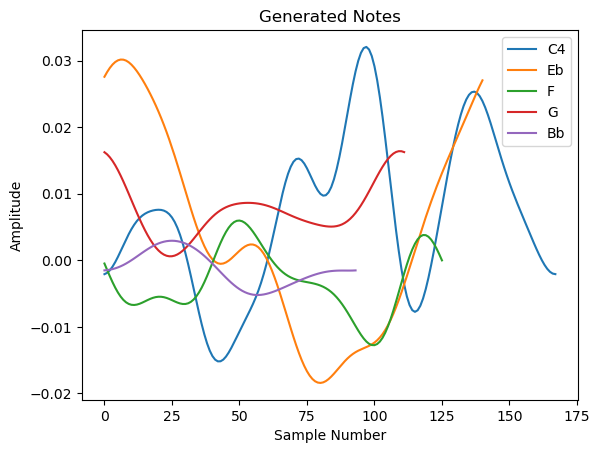

In [7]:
print('creating notes...')
for name, freq in list(pmNotes.items()):
    fileName = name +'.wav'
    data, buf = generateNote(freq)
    print('creating ' + fileName + '...')
    writeWAVE(fileName, data)
    # Display the Notes
    ax = plt.plot(buf, label=name)

    # add note to player
    nplayer.add(name + '.wav')
    plt.legend()
    plt.xlabel("Sample Number")
    plt.ylabel("Amplitude")
    plt.title("Generated Notes")

In [8]:
# List all files in the directory and filter for .wav files
directory_path = os.getcwd()
wav_files = [f for f in os.listdir(directory_path) if f.endswith('.wav')]

In [9]:
wav_files

['C4.wav', 'Eb.wav', 'F.wav', 'G.wav', 'Bb.wav']

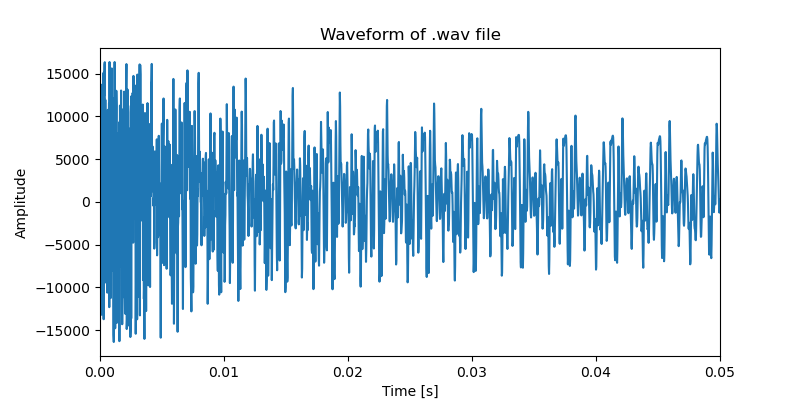

Playing file: C4.wav



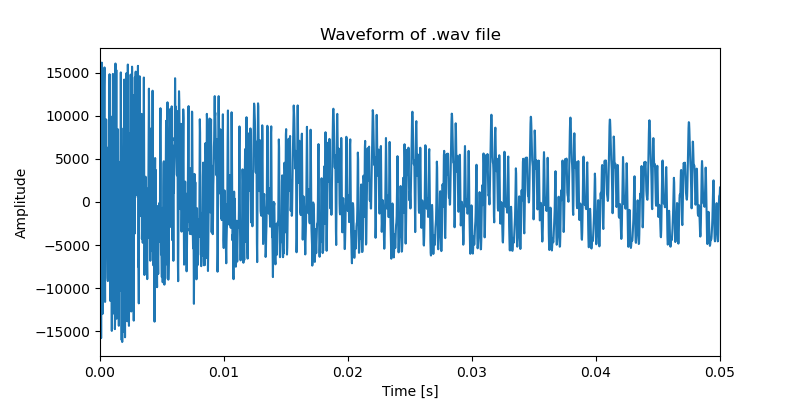

Playing file: Eb.wav



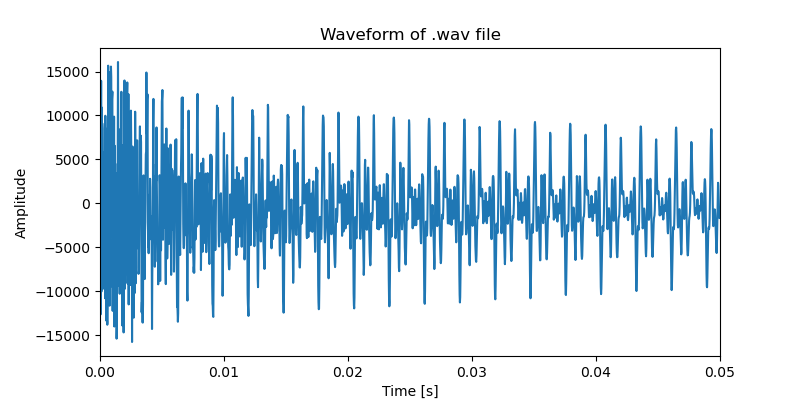

Playing file: F.wav



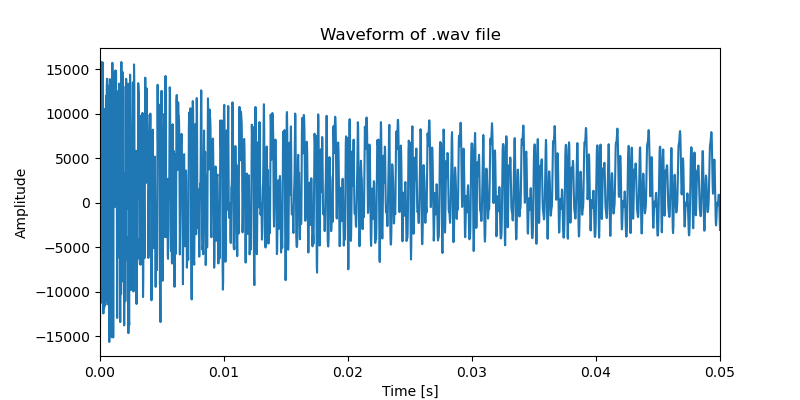

Playing file: G.wav



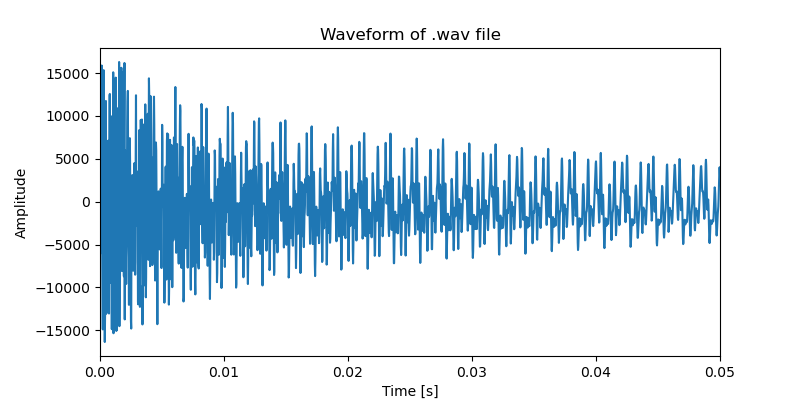

Playing file: Bb.wav



In [10]:
%matplotlib ipympl
from IPython.display import Audio, display
from scipy.io import wavfile

for wav_file in wav_files:
    file_path = os.path.join(directory_path, wav_file)
    sampling_rate, data = wavfile.read(file_path)
    # Check if the audio is mono or stereo and extract accordingly
    if len(data.shape) > 1:  # Stereo
        data = data.mean(axis=1)  # Convert to mono by averaging left and right channels

    # Create a time axis in seconds
    time = np.linspace(0, len(data) / sampling_rate, num=len(data))

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.plot(time, data)
    plt.title('Waveform of .wav file')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.xlim(0, 0.05)
    plt.show()
    
    display(Audio(filename=file_path))
    print(f"Playing file: {wav_file}")
    print()